# Unsupervised Clustering using VQE

### DataPoint
First, we'll have to create a DataPoint class, that can be used to store and compare input-datapoints. We'll do this as follows, including a ```dist``` function to compute the squared-distance between two datapoints:

In [47]:
from dataclasses import dataclass
from typing import List
import numpy as np


# Helper functions
def sqr(x: float):
    return x * x


class DataPoint:
    x: float
    y: float
    cluster: int = 0
    original_cluster: int = 0
    fidelity: float = 0.0
    init_x: int
    init_y: int

    def __init__(self, x: int, y: int, cluster):
        self.x = x
        self.y = y
        self.original_cluster = cluster
        self.cluster = cluster
        self.init_x = x
        self.init_y = y

    def dist(self, o: "DataPoint") -> float:
        return abs(o.init_x - self.init_x) + abs(o.init_y - self.init_y)


@dataclass
class Dataset:
    _clusters: List[List[DataPoint]]
    min_x: int = 0
    max_x: int = 0
    min_y: int = 0
    max_y: int = 0
    _complete = None

    cached_distance_matrix = None

    def __len__(self):
        return len(self.complete_dataset)

    @property
    def accuracy(self) -> float:
        # Accuracy metric: Correctly classified to the initial cluster / total
        total = 0
        correct = 0
        for cluster in self._clusters:
            for point in cluster:
                total += 1
                if point.original_cluster == point.cluster:
                    correct += 1

        return correct / total

    def __getitem__(self, item):
        return self.complete_dataset[item]

    @property
    def complete_dataset(self) -> List[DataPoint]:
        if self._complete is not None:
            return self._complete

        # normalize clusters
        for i in self._clusters:
            for j in i:
                j.x = (j.x - self.min_x) / (self.max_x - self.min_x)
                j.y = (j.y - self.min_y) / (self.max_y - self.min_y)
        # Compute the complete dataset and cache it
        self._complete = [point for cluster in self._clusters for point in cluster]
        return self._complete

    @staticmethod
    def gen_clusters(**kwargs) -> "Dataset":
        clusters = []

        min_x = np.inf
        min_y = np.inf

        max_x = -np.inf
        max_y = -np.inf

        for i in range(1, kwargs.get("clusters", 2) + 1):
            current_cluster = []
            # Load cluster parameters
            cluster_angle_start = kwargs.get(f"cluster_{i}_angle_start", 0)
            cluster_angle_end = kwargs.get(f"cluster_{i}_angle_end", 360)
            cluster_center_x = kwargs.get(f"cluster_{i}_center_x", 0)
            cluster_center_y = kwargs.get(f"cluster_{i}_center_y", 0)
            cluster_radius_start = kwargs.get(f"cluster_{i}_radius_start", 0)
            cluster_radius_end = kwargs.get(f"cluster_{i}_radius_end", 50)

            # Compute normalization terms
            min_x = min(min_x, cluster_center_x - cluster_radius_end)
            min_y = min(min_y, cluster_center_y - cluster_radius_end)

            max_x = max(max_x, cluster_center_x + cluster_radius_end)
            max_y = max(max_y, cluster_center_y + cluster_radius_end)

            # Generate the needed points
            for j in range(kwargs.get(f"cluster_{i}_size", 15)):
                angle = np.deg2rad(np.random.uniform(cluster_angle_start, cluster_angle_end))
                radius = np.random.uniform(cluster_radius_start, cluster_radius_end)
                x = cluster_center_x + radius * np.cos(angle)
                y = cluster_center_y + radius * np.sin(angle)
                current_cluster.append(DataPoint(x, y, cluster=i - 1))

            clusters.append(current_cluster)

        return Dataset(_clusters=clusters, min_x=min_x, min_y=min_y, max_x=max_x, max_y=max_y)

    @property
    def distance_matrix(self) -> np.array:
        """
        Distance matrix[i][j] = distance between i and j
        :return:
        """
        if self.cached_distance_matrix is not None:
            return self.cached_distance_matrix
        complete_dataset: List[DataPoint] = self.complete_dataset
        dataset_size = len(complete_dataset)
        distance_matrix = np.zeros(shape=(dataset_size, dataset_size))
        for i in range(dataset_size):
            for j in range(dataset_size):
                distance_matrix[i][j] = complete_dataset[i].dist(complete_dataset[j])
        self.cached_distance_matrix = distance_matrix
        return distance_matrix

    @staticmethod
    def blobs(cluster_1_size=100, cluster_2_size=100) -> "Dataset":
        """Generates points in blobs around the 20 and 80 point"""
        return Dataset.gen_clusters(
            clusters=2,
            cluster_1_size=cluster_1_size,
            cluster_1_center_x=20,
            cluster_1_center_y=50,
            cluster_1_radius_end=20,

            cluster_2_size=cluster_2_size,
            cluster_2_center_x=80,
            cluster_2_center_y=50,
            cluster_2_radius_end=20
        )

    @staticmethod
    def concave_clusters(cluster_1_size=100, cluster_2_size=100) -> "Dataset":
        return Dataset.gen_clusters(clusters=2,
                                    cluster_1_size=cluster_1_size,
                                    cluster_1_angle_start=0, cluster_1_angle_end=180,
                                    cluster_1_center_x=45, cluster_1_center_y=50,
                                    cluster_1_radius_start=8, cluster_1_radius_end=10,

                                    cluster_2_size=cluster_2_size,
                                    cluster_2_angle_start=180, cluster_2_angle_end=360,
                                    cluster_2_center_x=55, cluster_2_center_y=50,
                                    cluster_2_radius_start=8, cluster_2_radius_end=10, )

    @staticmethod
    def curved_lines(cluster_1_size=300, cluster_2_size=100) -> "Dataset":
        return Dataset.gen_clusters(clusters=2,
                                    cluster_1_size=cluster_1_size,
                                    cluster_1_angle_start=60, cluster_1_angle_end=230,
                                    cluster_1_center_x=50, cluster_1_center_y=50,
                                    cluster_1_radius_start=5, cluster_1_radius_end=20,

                                    cluster_2_size=cluster_2_size,
                                    cluster_2_angle_start=290, cluster_2_angle_end=340,
                                    cluster_2_center_x=60, cluster_2_center_y=60,
                                    cluster_2_radius_start=5, cluster_2_radius_end=20, )

    def plot(self, initial=False):
        clusters = [list() for i in self._clusters]
        clusters_initial = [list() for i in self._clusters]
        for i in self.complete_dataset:
            clusters[i.cluster].append(i)
            clusters_initial[i.original_cluster].append(i)

        if initial:
            fig, (ax2, ax1) = plt.subplots(1, 2)
            ax1.title.set_text("Clustered points")
            ax2.title.set_text("Initial points ")
        else:
            fig, ax1 = plt.subplots()
            ax2 = None

        for cluster in clusters:
            ax1.scatter(
                [point.x for point in cluster],
                [point.y for point in cluster]
            )

        if initial:
            for cluster in clusters_initial:
                ax2.scatter(
                    [point.x for point in cluster],
                    [point.y for point in cluster]
                )

        plt.show()

Also implement the ```map``` function, that can be used to map Data Points onto the Bloch Sphere:

In [40]:
def map(a: float, b: float, c: float, d: float, e: float) -> float:
    return d + ((a - b) / (c - b)) * (e - d)

### Qiskit
Now, we start working with Qiskit! Import all the necessary elements:

In [41]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.algorithms.optimizers import SPSA
from qiskit.quantum_info import state_fidelity

from tqdm import tqdm
import math

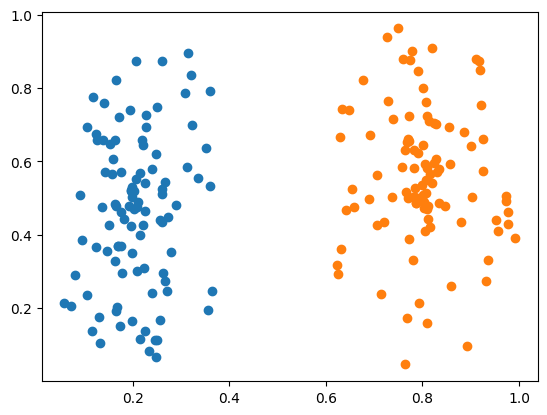

array([[ 0.        ,  9.78885212, 22.40123979, ..., 70.13979151,
        69.18274408, 46.72454585],
       [ 9.78885212,  0.        , 27.36624614, ..., 79.92864363,
        78.97159621, 56.51339797],
       [22.40123979, 27.36624614,  0.        , ..., 75.11384308,
        74.15679566, 57.41047485],
       ...,
       [70.13979151, 79.92864363, 75.11384308, ...,  0.        ,
         2.17312873, 23.41524565],
       [69.18274408, 78.97159621, 74.15679566, ...,  2.17312873,
         0.        , 22.45819823],
       [46.72454585, 56.51339797, 57.41047485, ..., 23.41524565,
        22.45819823,  0.        ]])

In [42]:
dataset = Dataset.blobs(100, 100)
dataset.plot()
dataset.distance_matrix


In [43]:
# Fix the np random seed
np.random.seed(12)

#
# Hard-code the data points that the algorithm will be performed on
#

# Hard-code the two reference states on the bloch-sphere that we will use as references for two clusters
#
# [1, 0] = |0> and [0, 1] = |1>
reference_points = [[1, 0], [0, 1]]

circuit_counter = 0


# Function: setup the variational form according to given parameters


def setup_variational_form(dp: DataPoint, params) -> QuantumCircuit:
    global circuit_counter

    q_circuit = QuantumCircuit(1)
    q_circuit.name = "circuit" + str(circuit_counter)
    circuit_counter += 1
    q_circuit.initialize([1, 0], 0)

    q_circuit.u(
        map(dp.x, 0, 1, params[2], params[3]),
        map(dp.y, 0, 1, params[4], params[5]),
        0,
        0
    )
    q_circuit.u(params[0], params[1], 0, 0)

    #print("Quantum Circuit:")
    #print(q_circuit)

    q_circuit.save_statevector()

    return q_circuit


def reference_point_circuit(params, ref_state) -> QuantumCircuit:
    global circuit_counter
    circuit_counter += 1

    q_circuit = QuantumCircuit(1)
    q_circuit.initialize(ref_state, 0)
    q_circuit.u(params[6], params[7], 0, 0)
    q_circuit.save_statevector()
    return q_circuit


#setup_variational_form(DataPoint(0, 0), [0, 0])

qiskit_backend = Aer.get_backend("aer_simulator")


def run_circuit_for_ref_point(params, ref_point):
    return qiskit_backend.run(
        transpile(
            reference_point_circuit(params, ref_point),
            backend=qiskit_backend
        )
    ).result().get_statevector()


def run_circuit_for_point(data_points, data_point_index: int, params):
    return qiskit_backend.run(
        transpile(
            setup_variational_form(data_points[data_point_index], params),
            backend=qiskit_backend
        )
    ).result().get_statevector()


ref_points = []


def objective_function_with_datapoints(data_points: Dataset):
    def objective(params) -> float:
        global ref_points

        state_lambda = lambda x: run_circuit_for_point(data_points, x, params)

        n = len(data_points)
        m = len(reference_points)
        ref_points = [run_circuit_for_ref_point(params, i) for i in reference_points]
        # Computing state fidelity
        state_cache = [state_lambda(i) for i in tqdm(range(n))]
        # Computing the fidelity matrix f(i, a) = fidelity between datapoint i and reference a
        fidelity_matrix = np.zeros(shape=(n, m))
        for i in range(n):
            for j in range(m):
                fidelity_matrix[i][j] = state_fidelity(state_cache[i], ref_points[j])

        # Computing the fidelity matrix f(i, j) = sum over all references [ f(i, a) * f(j, a) ]
        fidelity_sum_matrix = np.zeros(shape=(n, n))
        for i in range(n):
            for j in range(m):
                if i == j: continue
                if j < i:
                    fidelity_sum_matrix[i][j] = fidelity_sum_matrix[j][i]
                else:
                    fidelity_sum = np.dot(fidelity_matrix[i, :], fidelity_matrix[j, :])
                    fidelity_sum_matrix[i][j] = fidelity_sum

        # Cost function = sum over all distance[i][j] * fidelity_sum_matrix[i][j]
        cost = np.sum(np.multiply(data_points.distance_matrix, fidelity_sum_matrix))
        return cost

    return objective


# Select the right optimizer
optimizer = SPSA(maxiter=2)


def cluster_dataset(dataset: Dataset):
    # Initialize the parameters with random values
    params_init = np.random.rand(8)
    fun = objective_function_with_datapoints(dataset)
    # Perform the optimization and store the result
    optimal_params = optimizer.minimize(fun=fun, x0=params_init).x

    print(optimal_params)
    print("Total cost: " + str((fun(optimal_params))))

    n = len(dataset)
    m = len(ref_points)
    state_vectors = [run_circuit_for_point(dataset, i, optimal_params) for i in range(n)]
    fidelity_matrix = np.zeros(shape=(n, m))
    for i in range(n):
        for j in range(m):
            fidelity_matrix[i][j] = state_fidelity(state_vectors[i], ref_points[j])

    cluster_iter = iter(np.argmax(fidelity_matrix, axis=1))
    for i in dataset.complete_dataset:
        i.cluster = next(cluster_iter)
    dataset.plot(initial=True)
    print(f"Accuracy: {dataset.accuracy}")


/Users/inplmd/Documents/university/tn3175-quantum-project/code/venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/inplmd/Documents/university/tn3175-quantum-project/code/venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 200/200 [00:00<00:00, 436.51it/s]


[1.0520597  1.7794829  1.77000567 1.51435986 1.51368694 0.47840354
 1.15953192 1.66973822]


100%|██████████| 200/200 [00:00<00:00, 437.68it/s]


Total cost: 10.993702905812206


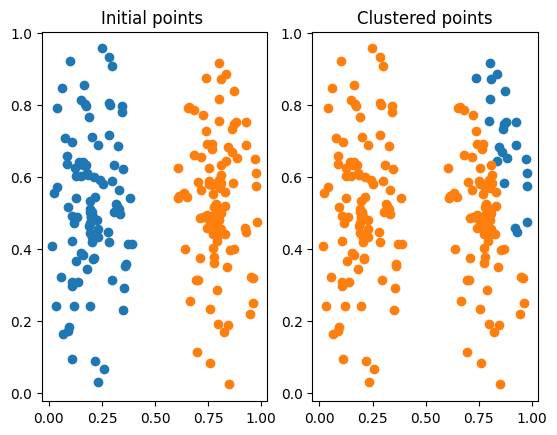

Accuracy: 0.385


In [44]:
cluster_dataset(Dataset.blobs(100, 100))

100%|██████████| 200/200 [00:00<00:00, 434.35it/s]


[-1.00596734  1.8787033   1.96998646  2.20099101  1.63247402  1.50457415
 -0.33464697 -0.9965253 ]


100%|██████████| 200/200 [00:00<00:00, 431.98it/s]


Total cost: 14.997606310708049


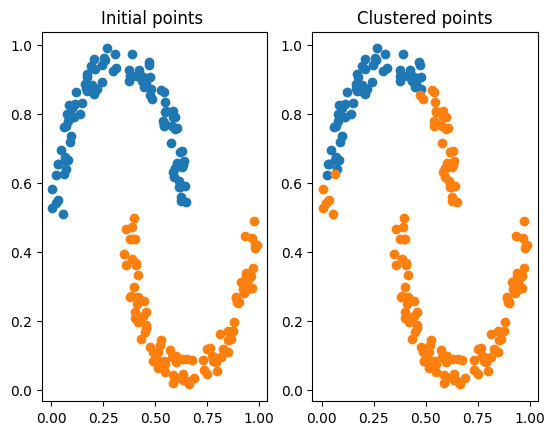

Accuracy: 0.8


In [49]:
cluster_dataset(Dataset.concave_clusters(100, 100))

/Users/inplmd/Documents/university/tn3175-quantum-project/code/venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/inplmd/Documents/university/tn3175-quantum-project/code/venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 400/400 [00:00<00:00, 434.61it/s]


[ 3.02181664 -0.59867065 -0.78602658 -0.71679938  0.989544    1.01680331
 -0.15876672 -1.95415642]


100%|██████████| 400/400 [00:00<00:00, 432.85it/s]


Total cost: 12.774905319240212


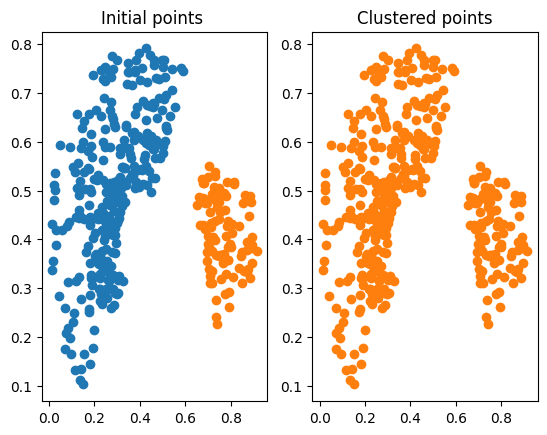

Accuracy: 0.25


In [48]:
cluster_dataset(Dataset.curved_lines())
